In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import scipy.stats as stats
import env
import wrangle_zillow as wz
import acquire
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from sklearn.model_selection import learning_curve

# Exercises

## Sourcing the Zillow database as the data source, create a jupyter notebook named explore_zillow and do the following:

1. Ask at least 5 questions about the data, keeping in mind that your target variable is logerror. e.g. Is logerror significantly different for properties in LA County vs Orange County vs Ventura County?

2. Answer those questions through a mix of statistical tests and visualizations.

In [2]:
df = acquire.get_zillow_data()

In [3]:
# make sure data is pulled in
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77614 entries, 0 to 77613
Data columns (total 80 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            77614 non-null  int64  
 1   parcelid                      77614 non-null  int64  
 2   airconditioningtypeid         21457 non-null  float64
 3   architecturalstyletypeid      151 non-null    float64
 4   basementsqft                  45 non-null     float64
 5   bathroomcnt                   77614 non-null  float64
 6   bedroomcnt                    77614 non-null  float64
 7   buildingclasstypeid           383 non-null    float64
 8   buildingqualitytypeid         50322 non-null  float64
 9   calculatedbathnbr             74391 non-null  float64
 10  decktypeid                    513 non-null    float64
 11  finishedfloor1squarefeet      5973 non-null   float64
 12  calculatedfinishedsquarefeet  76502 non-null  float64
 13  f

In [4]:
# Restrict df to only properties that meet single use criteria
single_use = [261, 262, 263, 264, 266, 268, 273, 276, 279]
df = df[df.propertylandusetypeid.isin(single_use)]

# Restrict df to only those properties with at least 1 bath & bed and 350 sqft area
df = df[(df.bedroomcnt > 0) & (df.bathroomcnt > 0) & ((df.unitcnt<=1)|df.unitcnt.isnull())\
            & (df.calculatedfinishedsquarefeet>350)]


In [5]:
def handle_missing_values(df, prop_required_column = .5, prop_required_row = .75):
# function that will drop rows or columns based on the percent of values that are missing:\
# handle_missing_values(df, prop_required_column, prop_required_row
    threshold = int(round(prop_required_column*len(df.index),0))
    df = df.dropna(axis=1, thresh=threshold)
    threshold = int(round(prop_required_row*len(df.columns),0))
    df.dropna(axis=0, thresh=threshold, inplace=True)
    return df

In [6]:
# Handle missing values i.e. drop columns and rows based on a threshold
df = handle_missing_values(df)
df.head()

id  parcelid  bathroomcnt  bedroomcnt  buildingqualitytypeid  \
20  20  11324547          2.0         4.0                    8.0   
30  30  11524947          2.0         2.0                    7.0   
31  31  11544747          4.0         3.0                   11.0   
33  33  11585547          2.0         3.0                    8.0   
37  37  11617547          3.0         2.0                    NaN   

    calculatedbathnbr  calculatedfinishedsquarefeet  finishedsquarefeet12  \
20                2.0                        3633.0                3633.0   
30                2.0                        1090.0                1090.0   
31                4.0                        1620.0                1620.0   
33                2.0                        2077.0                2077.0   
37                3.0                        2735.0                2735.0   

      fips  fullbathcnt  ...  heatingorsystemdesc  id.1  parcelid.1  logerror  \
20  6037.0          2.0  ...              Central    20    12325145  0.042463   
30  6037.0          2.0  ...              Central    30    12713253  0.021853   
31  6037.0          4.0  ...              Central    31    14338242 -0.019546   
33  6037.0          2.0  ...              Central    33    12155445 -0.040807   
37  6037.0          3.0  ...              Central    37    11682477  0.026208   

   transactiondate  id.2 last_trans_date  propertylandusetypeid.1  \
20      2017-01-02    20      2017-01-02                      261   
30      2017-01-02    30      2017-01-02                      266   
31      2017-01-02    31      2017-01-02                      261   
33      2017-01-02    33      2017-01-02                      261   
37      2017-01-02    37      2017-01-02                      266   

          propertylandusedesc  parcelid.2  
20  Single Family Residential    11324547  
30                Condominium    11524947  
31  Single Family Residential    11544747  
33  Single Family Residential    11585547  
37                Condominium    11617547  

[5 rows x 41 columns]

In [7]:
# Add column for counties
df['county'] = df['fips'].apply(
        lambda x: 'Los Angeles' if x == 6037\
        else 'Orange' if x == 6059\
        else 'Ventura')

# drop unnecessary columns
dropcols = ['parcelid',
         'calculatedbathnbr',
         'finishedsquarefeet12',
         'fullbathcnt',
         'heatingorsystemtypeid',
         'propertycountylandusecode',
         'propertylandusetypeid',
         'propertyzoningdesc',
         'censustractandblock',
         'propertylandusedesc']



# replace nulls in unitcnt with 1
df.unitcnt.fillna(1, inplace = True)

# assume that since this is Southern CA, null means 'None' for heating system
df.heatingorsystemdesc.fillna('None', inplace = True)

# replace nulls with median values for select columns
df.lotsizesquarefeet.fillna(7313, inplace = True)
df.buildingqualitytypeid.fillna(6.0, inplace = True)

# Columns to look for outliers
df = df[df.taxvaluedollarcnt < 5_000_000]
df = df[df.calculatedfinishedsquarefeet < 8000]

# Just to be sure we caught all nulls, drop them here
#df = df.dropna()

def remove_columns(df, cols_to_remove):
#remove columns not needed
    df = df.drop(columns=cols_to_remove)
    return df

In [8]:
df = remove_columns(df, dropcols)

In [9]:
df.shape

(67775, 32)

In [11]:
df.fips.value_counts()

6037.0    44412
6059.0    17687
6111.0     5676
Name: fips, dtype: int64

In [12]:
train, validate, test = wz.train_validate_test_split(df)

In [13]:
df = train

In [14]:
train.head()

id  bathroomcnt  bedroomcnt  buildingqualitytypeid  \
37313  37313          1.0         2.0                    4.0   
66422  66422          1.0         2.0                    4.0   
3227    3227          2.0         4.0                    8.0   
38522  38522          2.0         4.0                    6.0   
53169  53169          3.0         5.0                    9.0   

       calculatedfinishedsquarefeet    fips    latitude    longitude  \
37313                         930.0  6037.0  33862275.0 -118189497.0   
66422                        1236.0  6037.0  33902281.0 -118243714.0   
3227                         2303.0  6037.0  34554752.0 -118101333.0   
38522                        1480.0  6037.0  33906343.0 -118035658.0   
53169                        2840.0  6037.0  33788118.0 -118353475.0   

       lotsizesquarefeet  rawcensustractandblock  ...  heatingorsystemdesc  \
37313             4700.0            6.037570e+07  ...           Floor/Wall   
66422             6118.0            6.037543e+07  ...           Floor/Wall   
3227              6826.0            6.037911e+07  ...              Central   
38522             5490.0            6.037504e+07  ...              Central   
53169            17919.0            6.037670e+07  ...              Central   

        id.1  parcelid.1  logerror  transactiondate   id.2  last_trans_date  \
37313  37313    12827799 -0.019834       2017-05-18  37313       2017-05-18   
66422  66422    17227729  0.053584       2017-08-14  66422       2017-08-14   
3227    3227    17085188 -0.124115       2017-01-17   3227       2017-01-17   
38522  38522    13996901  0.010197       2017-05-22  38522       2017-05-22   
53169  53169    14362589  0.058206       2017-06-30  53169       2017-06-30   

       propertylandusetypeid.1  parcelid.2       county  
37313                      261    12453257  Los Angeles  
66422                      261    12274740  Los Angeles  
3227                       261    11238981  Los Angeles  
38522                      261    12748312  Los Angeles  
53169                      261    12691650  Los Angeles  

[5 rows x 32 columns]

### My questions
frame my questions with the tools we can use:
- univariate exploration
- bivariate exploration
- multivariate exploration

### What is the distribution of the variables?
### 1. Univariate exploration

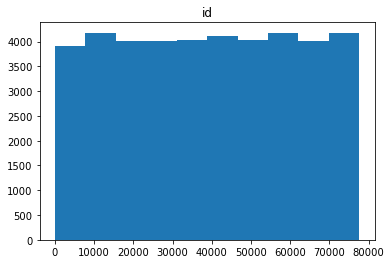

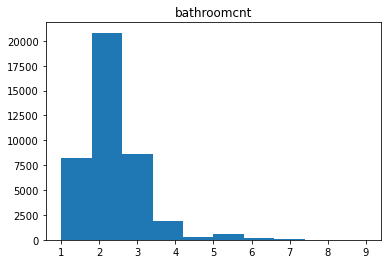

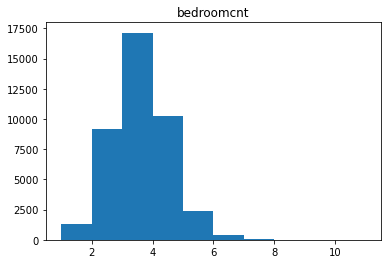

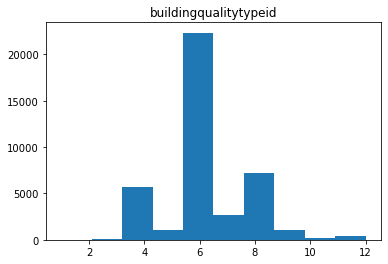

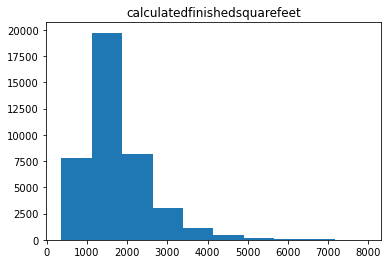

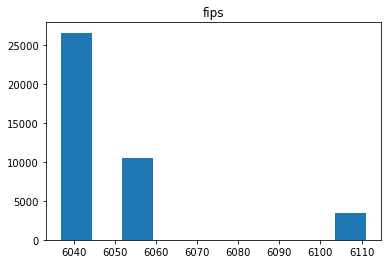

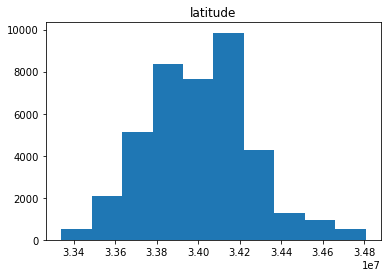

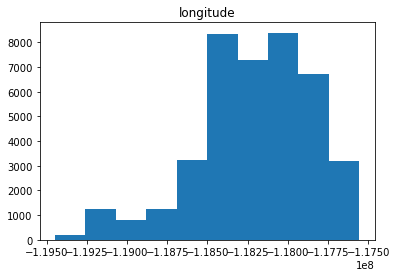

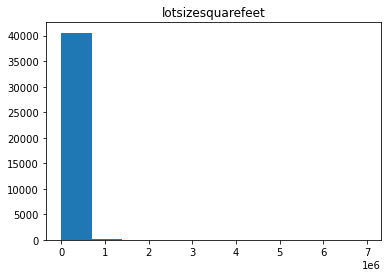

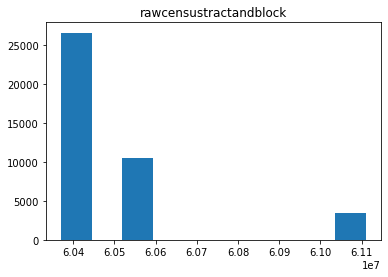

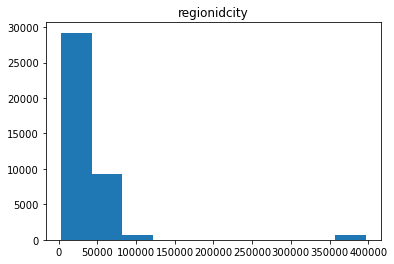

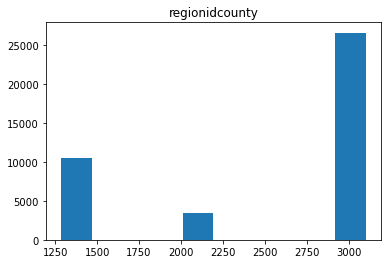

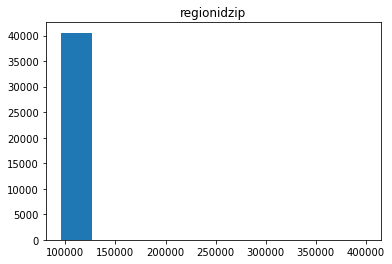

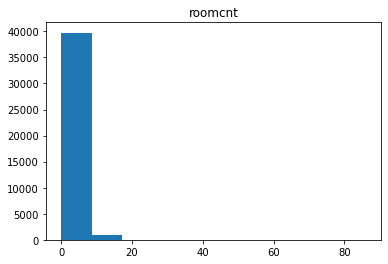

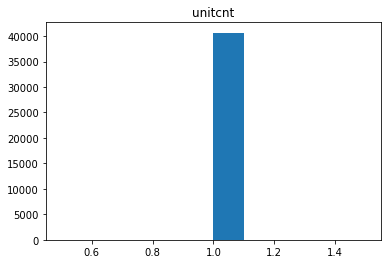

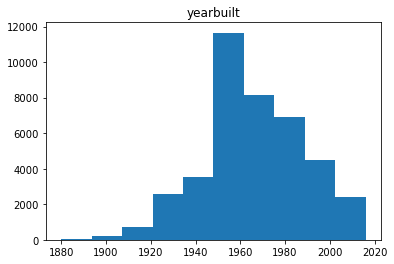

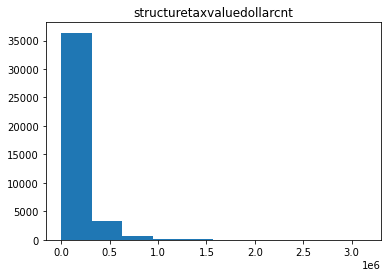

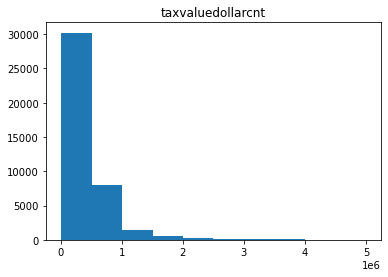

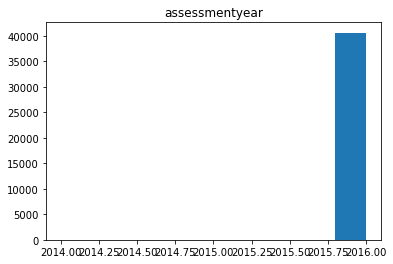

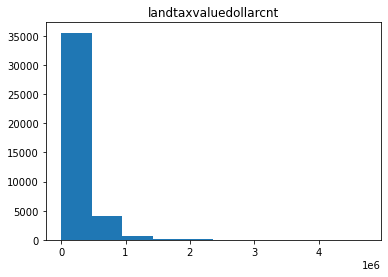

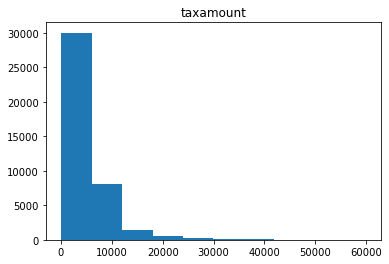

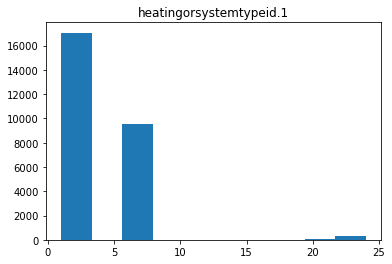

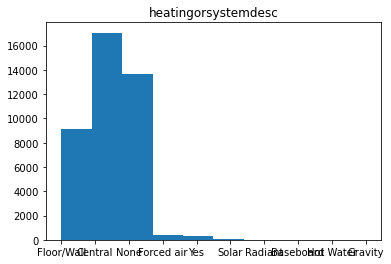

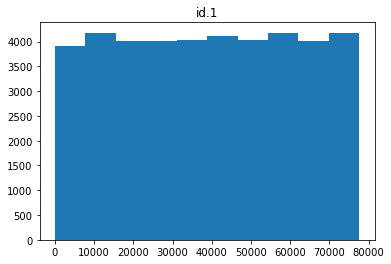

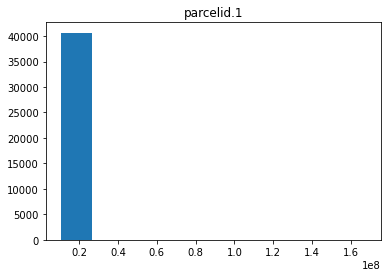

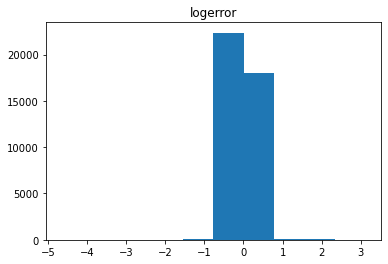

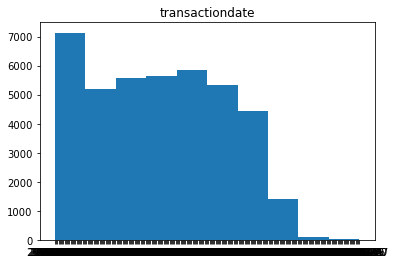

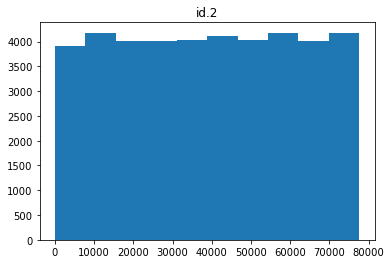

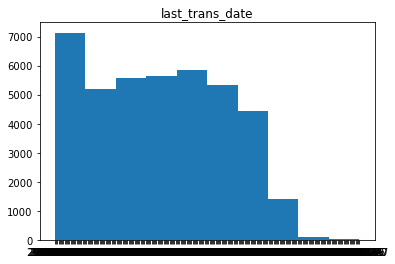

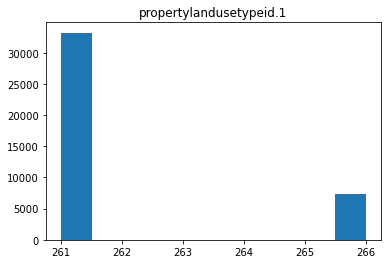

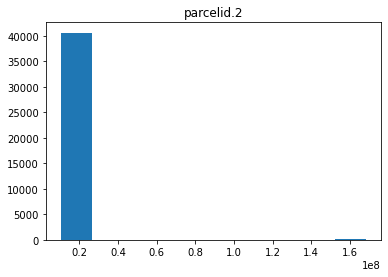

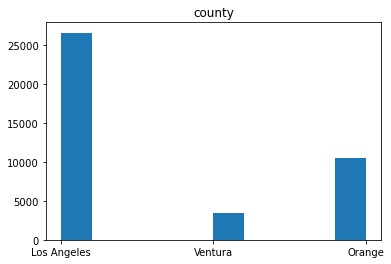

In [16]:
 
for col in train.columns:
    plt.hist(train[col])
    plt.title(col)
    plt.show()

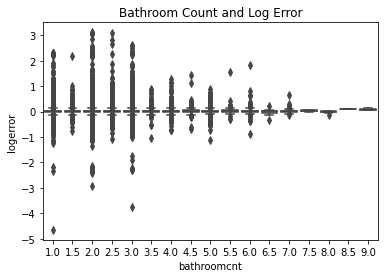

In [17]:
sns.boxplot(train.bathroomcnt, train.logerror)
plt.title('Bathroom Count and Log Error')
plt.show()

### Univariate Takeaways
- Roughly normal distribution
  - bathroomcnt, bedroomcnt, latitude
- Left skewed distributions
  - longitude

### 1. Bivariate:
- Does logerror vary across fips?

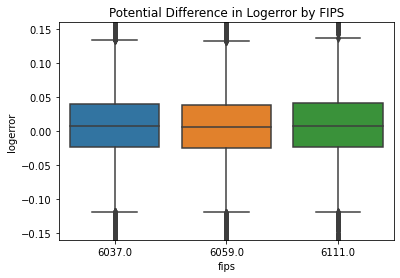

In [18]:

sns.boxplot(train['fips'], train['logerror'])
plt.title('Potential Difference in Logerror by FIPS')
plt.ylim(-.16, .16)
plt.show()

In [19]:
# null hyothesis: mean_6037 == mean_6111
# alt hypothesis: mean_is_6037 != mean_6111

# Using levene to test variance
print(stats.levene(train[train.fips==6037].logerror, train[train.fips==6111].logerror))

# using two sample, two tailed ttest
print(stats.ttest_ind(train[train.fips==6037].logerror, train[train.fips==6111].logerror, equal_var=False))

LeveneResult(statistic=0.0035582457578468367, pvalue=0.9524339683492639)
Ttest_indResult(statistic=-0.9385997698360559, pvalue=0.34798856742318707)


### Takeaways:
- due to the high p value, we fail to reject the null hypothesis

### 2. Is logerror significantly different across zip codes/counties

In [21]:
train.fips.value_counts()

6037.0    26644
6059.0    10580
6111.0     3441
Name: fips, dtype: int64

- 06111 = Ventura
- 6037 = Los Angeles
- 6059 = Orange 

In [22]:
train.county.value_counts()

Los Angeles    26644
Orange         10580
Ventura         3441
Name: county, dtype: int64

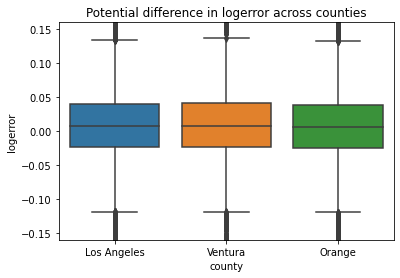

In [23]:
sns.boxplot(train.county, train.logerror)
plt.title('Potential difference in logerror across counties')
plt.ylim(-.16, .16)
plt.show()


###
- LA county vs Orange County
- presume our target is roughly normal, so we can go about using a t-test
- Test for equal variance:
- $Ho$: variance in the logerror in Orange County and Los Angeles are equivalent
- alpha = 0.05

In [26]:

stats.levene(train[train.county == 'Los Angeles'].logerror, train[train.county == 'Orange'].logerror)

LeveneResult(statistic=0.035804190527656585, pvalue=0.8499214617816814)

### Fail to reject the null as the p value is greater at 0.85 that our alpha at 0.05

### 3. Is there a relation between square footage and logerror, linear correlation or otherwise?

Relationship between Square footage and Logerror?


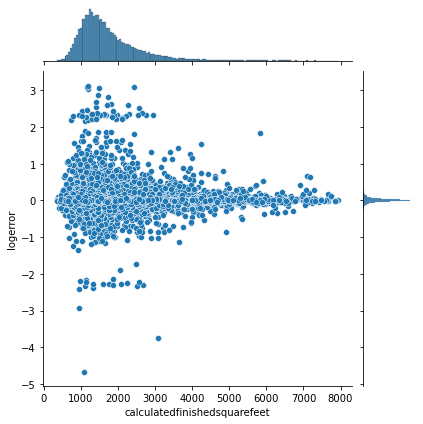

In [27]:
print('Relationship between Square footage and Logerror?')
sns.jointplot(x='calculatedfinishedsquarefeet', y='logerror', data=train)
plt.xlabel('Calculated Finished Square Feet')
plt.ylabel('Logerror')
plt.show()

###  Takeaway: 
There apppears to be no distinct clusters or linear relationship between square footage and 
 logerror, though the spread of outliers as square footage increases suggests it may be useful going forward in 
 multivariate analysis or feature engineering

##  4. Is there a relationship between longitude and logerror?

Relationship between Longitude and Logerror?


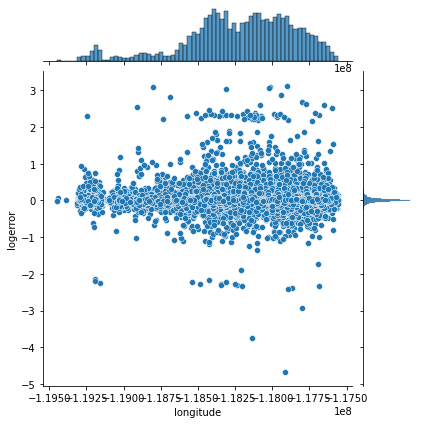

In [28]:
print('Relationship between Longitude and Logerror?')
sns.jointplot(x='longitude', y='logerror', data=train)
plt.xlabel('Longitude')
plt.ylabel('Logerror')
plt.show()

### 4.5 Is there a relationship between bedroomcount and logerror? 

Relationship between Bedroom count and Logerror?


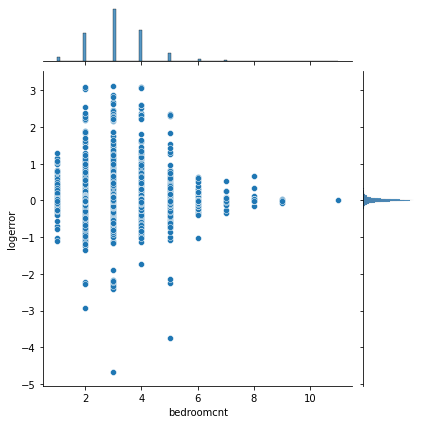

In [29]:
print('Relationship between Bedroom count and Logerror?')
sns.jointplot(x='bedroomcnt', y='logerror', data=train)
plt.xlabel('Bedroom Count')
plt.ylabel('Logerror')
plt.show()

### Observation: 
There appears to be a division between properties with more than 5 bedrooms having less error than those with less than 5 bedrooms

$Ho$: Variance in logerror for homes with 5 or less bedrooms is equivalent to those with more than 5 bedrooms
- alpha of 0.05

In [30]:
stats.levene(train[train.bedroomcnt > 5].logerror, train[train.bedroomcnt <= 5].logerror)

LeveneResult(statistic=1.0079610942274786, pvalue=0.3153977678808655)

#### Fail to reject the null hypothosis as the p value of 0.32 is higher than our alpha of 0.05 

### 5. Accounting for Bedroom counts, is there a relationship between error and geolocation via long/lat?

In [31]:
train['abs_logerr'] = train.logerror.apply(lambda x: x if x >= 0 else -x)

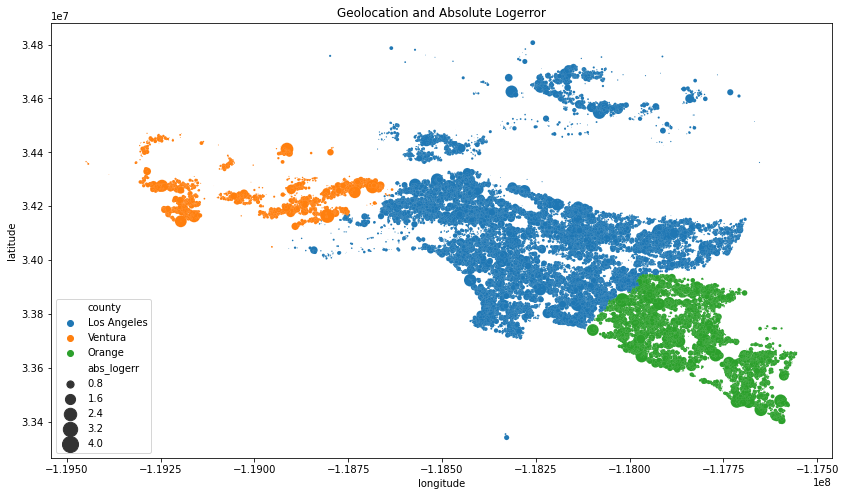

In [32]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='longitude', y='latitude', hue='county', size='abs_logerr', sizes=(0,300), data=train)
plt.legend()
plt.title('Geolocation and Absolute Logerror')
plt.show()

In [33]:
train['bedroom_bin'] = pd.cut(train.bedroomcnt, [0,4,10])

In [34]:
train.bedroom_bin.value_counts()

(0, 4]     37852
(4, 10]     2812
Name: bedroom_bin, dtype: int64

In [35]:
train[train.bedroomcnt <= 4].shape

(37852, 34)

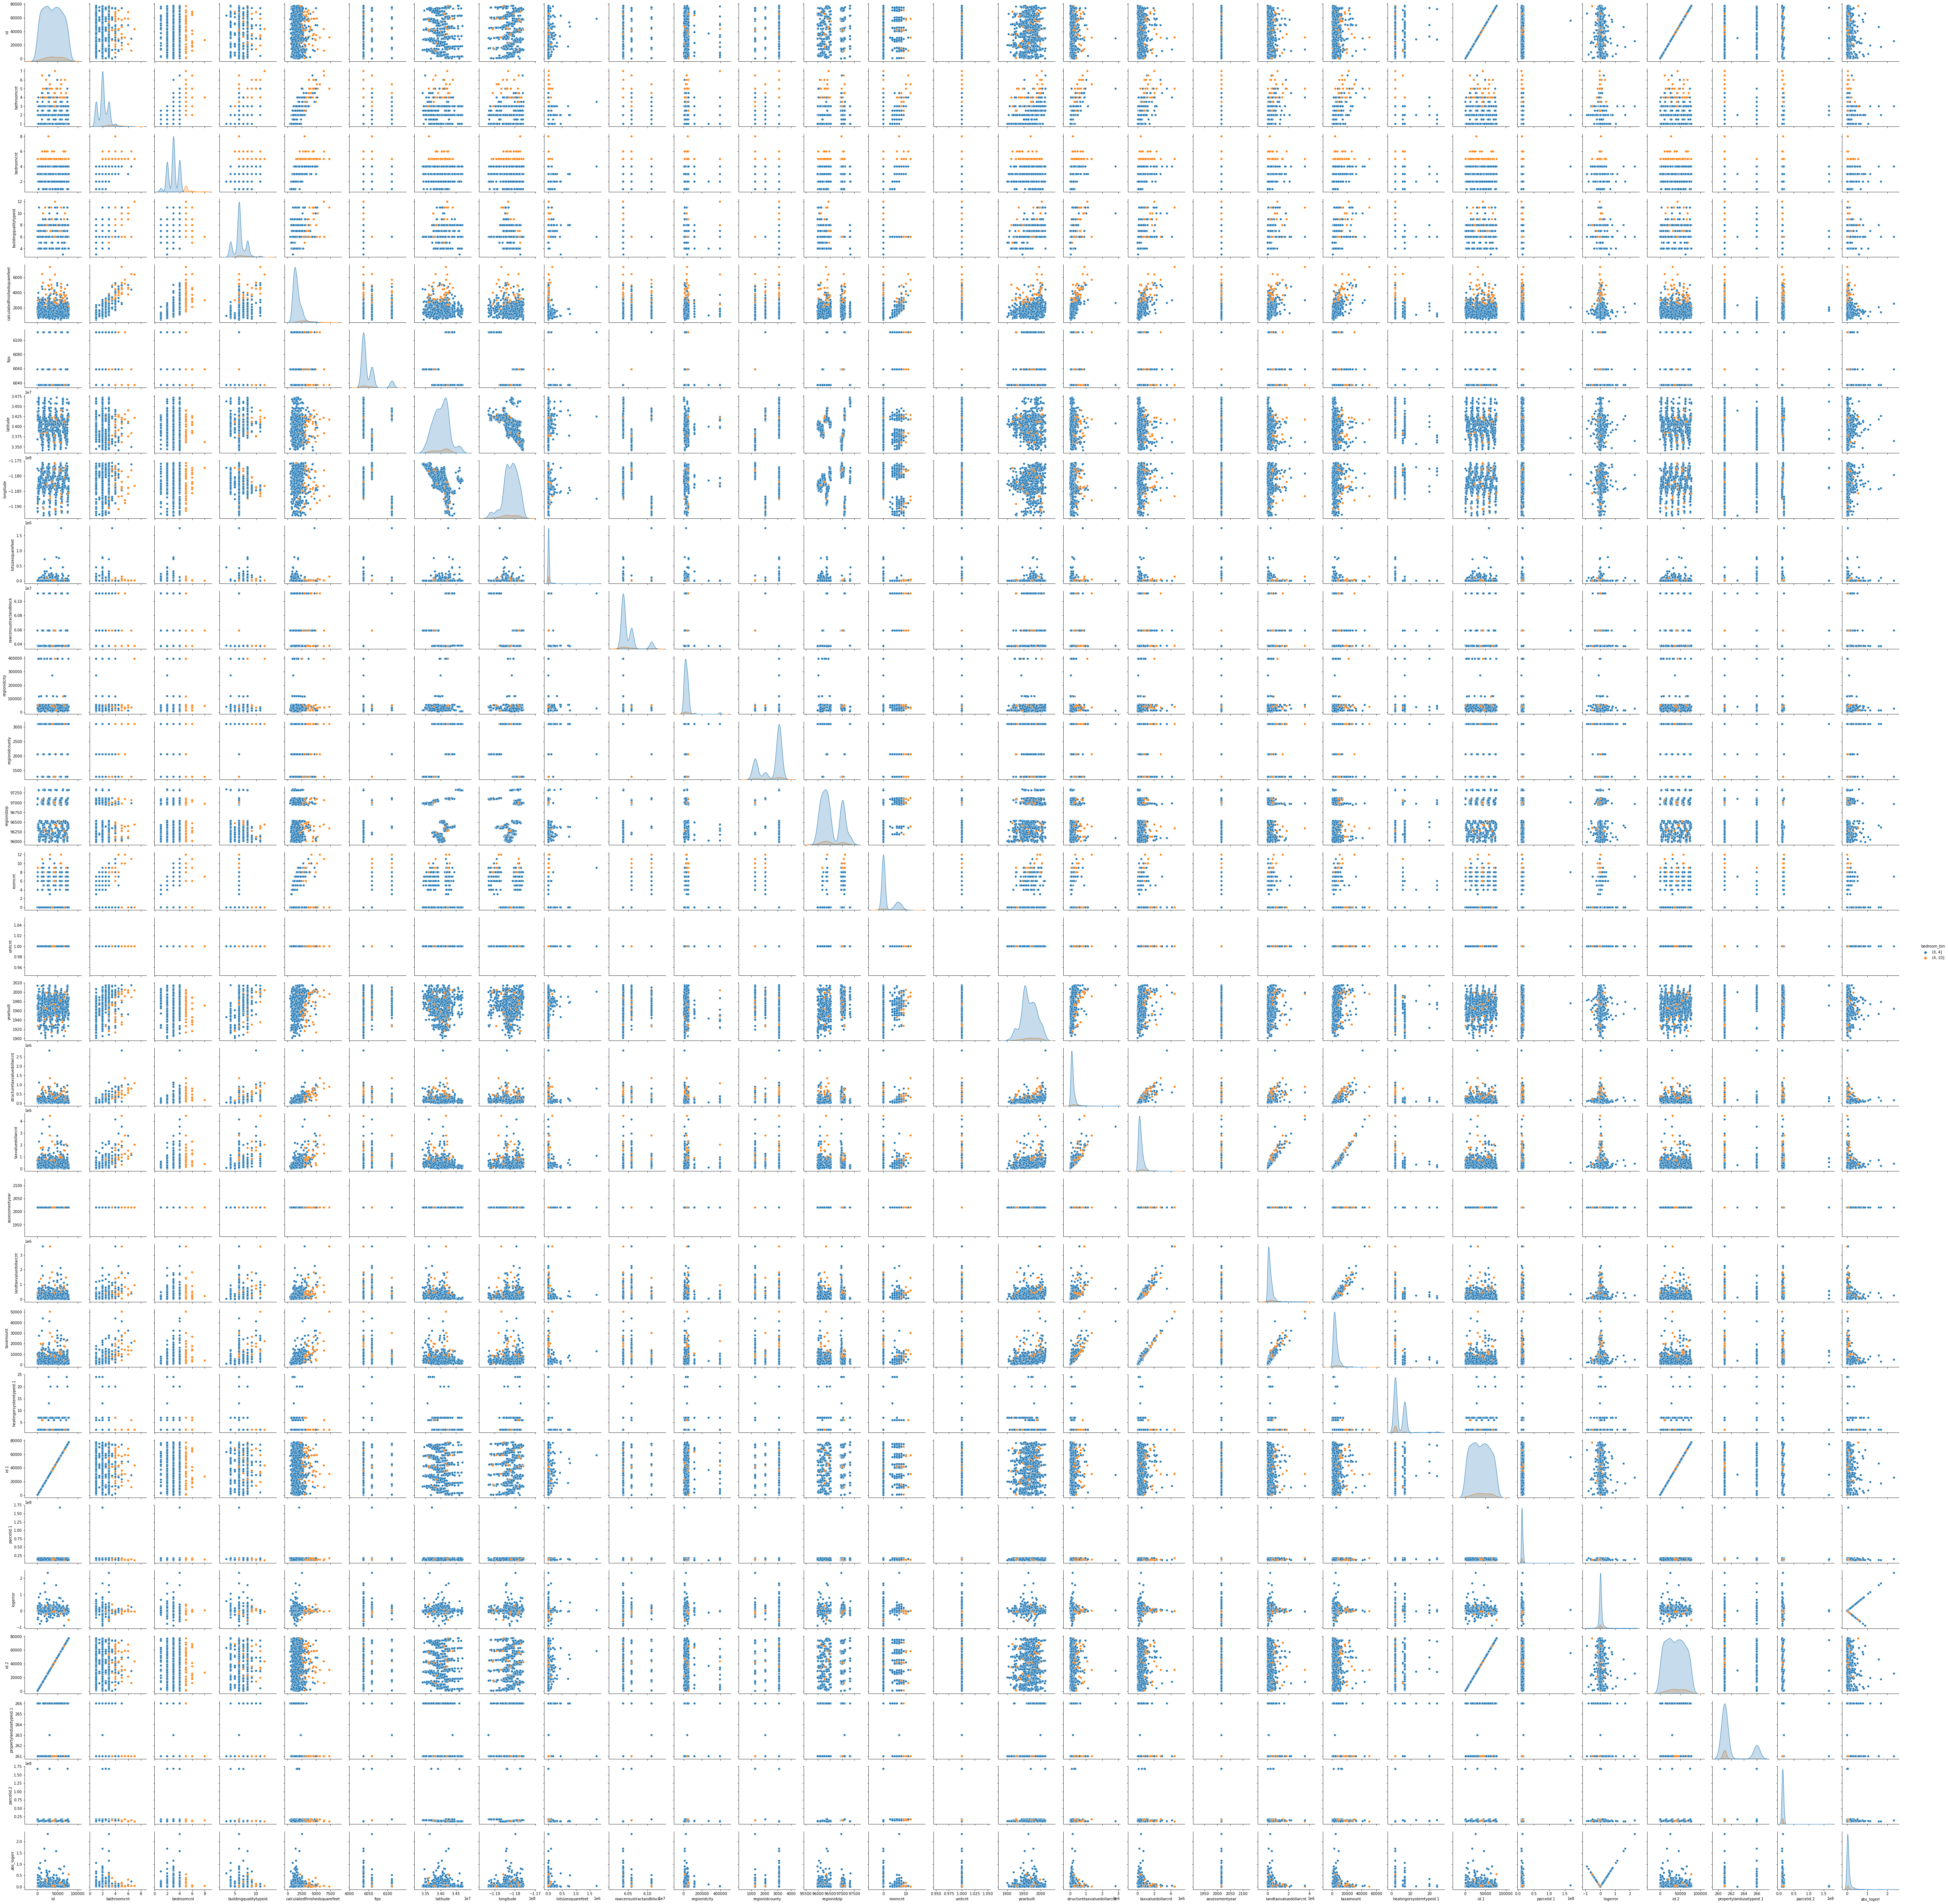

In [36]:
sns.pairplot(train.sample(1000), hue='bedroom_bin')